In [2]:
# set this notebook one level above State_denoise_RNN. Then we can just keep 
# track of it with git and exchange it between the server and local
import os
path = os.getcwd()
# if "State" not in path:
#     subdirectory = "attractor_net_notebooks"
#     path = os.getcwd()[:-len(subdirectory)] + 'State_Denoised_RNN'
print(path)
# os.chdir(path)

/Users/denis/Dropbox/school/research/attractor_net_notebooks


In [3]:
from __future__ import print_function, division
import itertools
import tensorflow as tf
import numpy as np
import sys
import argparse
import datetime
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10,5)


%load_ext autoreload
%autoreload 2

import sys
def progress_print(i, total, spacing=20):
    if i % spacing == 0:
        string_params_tuple = (i, total)
        sys.stdout.write("\r%i / %i" % string_params_tuple)
        sys.stdout.flush()

In [31]:
from tensorflow_helpers import *
from data_generator import generate_examples, pick_task
from information_trackers import MutInfSaver, WeightSaver
from helper_functions import get_batches, load_pretrained_embeddings, print_model_type, translate_ids_to_words

In [5]:
# Layer Normalization [https://theneuralperspective.com/2016/10/27/gradient-topics/]
def ln(inputs, epsilon = 1e-5, scope = None):
 
    """ Computer LN given an input tensor. We get in an input of shape
    [N X D] and with LN we compute the mean and var for each individual
    training point across all it's hidden dimensions rather than across
    the training batch as we do in BN. This gives us a mean and var of shape
    [N X 1].
    """
    mean, var = tf.nn.moments(inputs, [1], keep_dims=True)
    with tf.variable_scope(scope + 'LN'):
        scale = tf.get_variable('alpha',
                                shape=[inputs.get_shape()[1]],
                                initializer=tf.constant_initializer(1))
        shift = tf.get_variable('beta',
                                shape=[inputs.get_shape()[1]],
                                initializer=tf.constant_initializer(0))
    LN = scale * (inputs - mean) / tf.sqrt(var + epsilon) + shift
 
    return LN

In [52]:
#!/usr/local/bin/python

# This version of the code trains the attractor connections with a separate
# objective function than the objective function used to train all other weights
# in the network (on the prediction task).

from __future__ import print_function
import itertools
import tensorflow as tf
import numpy as np
import sys
import argparse

ops = {
        'model_type': "GRU", # OPTIONS: vanilla, LSTM_raw, LSTM_tensorflow, LSTM_attractor
        'hid': 20,
        'in': None, #TBD
        'out': 1,
#         'batch_size':n_examples, #since the sequences are 1-dimensional it's easier to just run them all at once
        'n_attractor_iterations': 5,
        'attractor_dynamics': "projection2", # OPTIONS:  "" (for no attractor dynamics),
                                    #           "direct" (simple attractor weights applied to hidden states directly, trained with noise addition)
                                    #           "projection" (project the hidden state into a separate space via weights, do attraction, project back)
                                    #           "helper_hidden" (hidden-hidden neurons) - IMPORTANT: don't forget to add h_hid number
        'h_hid': 25, # helper hidden for "helper hidden" "attractory_dynamics" mode
        'attractor_noise_level': 0.2,
        'attractor_noise_type': "bernoilli", # OPTIONS: "gaussian", "dropout", "random_drop"
    
        'training_mode': "",#'attractor_on_both',
    
        'attractor_regularization': "l2", # OPTIONS: "l2", ""
        'attractor_regularization_lambda': 0.05,
    
        'record_mutual_information': True,
        'problem_type': "pos_brown", # OPTIONS: parity, parity_length, majority, reber, kazakov, pos_brown
        'seq_len': None,
        'load_word_embeddings': True,
        'train_word_embeddings': False, 
        'save_best_model': True, 
        'reshuffle_data_each_replication': False, #relevant for POS datasets (since they are loaded from files)
        'test_partition': 0.3
        }



# !!!!!!!!!!!!!!!!!!!!!!            
# SEQ_LEN = 12 # number of bits in input sequence   
N_HIDDEN = ops['hid']  # number of hidden units
N_H_HIDDEN = ops['h_hid']          
TASK = ops['problem_type']
ARCH = ops['model_type'] # hidden layer type: 'GRU' or 'tanh'
NOISE_LEVEL = ops['attractor_noise_level']
                      # noise in training attractor net 
                      # if >=0, Gaussian with std dev NOISE_LEVEL 
                      # if < 0, Bernoulli dropout proportion -NOISE_LEVEL 
            
# !!!!!!!!!!!!!!!!!!!!!! 
INPUT_NOISE_LEVEL = 0.1
ATTRACTOR_TYPE = ops['attractor_dynamics']
N_ATTRACTOR_STEPS = ops['n_attractor_iterations']
                      # number of time steps in attractor dynamics
                      # if = 0, then no attractor net
# !!!!!!!!!!!!!!!!!!!!!!            
# ATTR_WEIGHT_CONSTRAINTS = True
                      # True: make attractor weights symmetric and have zero diag
                      # False: unconstrained
TRAIN_ATTR_WEIGHTS_ON_PREDICTION = False
                      # True: train attractor weights on attractor net _and_ prediction
REPORT_BEST_TRAIN_PERFORMANCE = True
                      # True: save the train/test perf on the epoch for which train perf was best
LOSS_SWITCH_FREQ = 1
                      # how often (in epochs) to switch between attractor 
                      # and prediction loss

ops, SEQ_LEN, N_INPUT, N_CLASSES, N_TRAIN, N_TEST = pick_task(ops['problem_type'], ops)# task (parity, majority, reber, kazakov)


# Training Parameters

TRAINING_EPOCHS = 5000
N_REPLICATIONS = 30
BATCH_SIZE = 10000
DISPLAY_EPOCH = 1
LRATE_PREDICTION = 0.008
LRATE_ATTRACTOR = 0.008


# NOTEBOOK CODE

WS = WeightSaver()
MIS = MutInfSaver()
tf.reset_default_graph()

# the tf seed needs to be within the context of the graph. 
np.random.seed(100)
tf.set_random_seed(100)





################ GLOBAL VARIABLES ######################################################
attr_net = attractor_net_init(ops)

######### MAIN CODE #############################################################

#
# PLACEHOLDERS
#
if 'pos' in ops['problem_type']:
    # X will be looked up in the embedding table, so the last dimension is just a number
    X = tf.placeholder("int64", [None, SEQ_LEN], name='X')
    # last dimension is left singular, tensorflow will expect it to be an id number, not 1-hot embed
    Y = tf.placeholder("int64", [None, SEQ_LEN], name='Y')
else: #single output
    X = tf.placeholder("float", [None, SEQ_LEN, N_INPUT])
    Y = tf.placeholder("float", [None, N_CLASSES])
attractor_tgt_net = tf.placeholder("float", [None, N_HIDDEN], name='attractor_tgt')

# Embedding matrix initialization
if 'pos' in ops['problem_type']:
    if ops['load_word_embeddings']:
        [X_train, Y_train, X_test, Y_test, maps] = generate_examples(SEQ_LEN, N_TRAIN, N_TEST, 
                                                                         INPUT_NOISE_LEVEL, TASK, ops)
        embeddings_loaded = load_pretrained_embeddings('data/glove.6B.50d.txt', maps, N_INPUT)
        embedding = tf.get_variable("embedding",
                                initializer=embeddings_loaded,
                                dtype=tf.float32,
                                trainable=ops['train_word_embeddings'])
    else: #initialize randomly
        embedding = tf.get_variable("embedding",
                                initializer=tf.truncated_normal_initializer(stddev=0.05),
                                shape=[ops['vocab_size'], N_HIDDEN],
                                dtype=tf.float32,
                                trainable=ops['train_word_embeddings'])
    embed = tf.nn.embedding_lookup(embedding, X)

#
# GRAPH structuring
#
params = GRU_params_init(ops)
params['attr_net'] = attr_net
if 'pos' in ops['problem_type']:
    # pass in the embedding instead of direct index tensor
    [Y_, h_net_seq, h_attractor_collection, h_clean_seq] = GRU(embed, ops, params)
    
    # mask out irrelevant h:
    # since all hs are (seq_len, batch, h_hid), transpose mask
    Y_transposed = tf.transpose(Y, [1,0]) # (batch_size, seq_len) -> (seq_len, batch_size) 
    mask_flat = tf.cast(tf.sign(Y_transposed), dtype="bool") # 0->False, 1->True
    indices_to_collect = tf.where(mask_flat)
    
    # gather_nd will grab the whole row (hidden vector) since indices_to_collect is (dim-1)
    h_collected = tf.gather_nd(h_net_seq, indices_to_collect)
    h_clean_seq_collect = tf.gather_nd(h_clean_seq, indices_to_collect)
    
    h_clean_seq = tf.reshape(h_clean_seq_collect, [-1, ops['hid']])
    h_net_seq = tf.reshape(h_collected, [-1, ops['hid']])
else:
    [Y_, h_net_seq, h_attractor_collection, h_clean_seq] = GRU(X, ops, params)
    h_net_seq = tf.reshape(h_net_seq, [-1, ops['hid']]) # (seq_len, batch, hid) -> (..., hid)

#
# LOSS
#
if 'pos' in ops['problem_type']:# cross entropy loss for sequence tagging
    # Y_: (batch_size, seq_len, n_classes), Y: (batch, seq_len)
    fake_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=Y_, labels=Y)
#     collapsed_class_Y = tf.reduce_max(Y, axis=2)
    mask = tf.cast(tf.sign(Y), dtype=tf.float32)
    loss_per_example_per_step = fake_loss*mask #since we only care about information with the real class
    loss_per_example_sum = tf.reduce_sum(loss_per_example_per_step, reduction_indices=[1])
    loss_per_example_average = loss_per_example_sum/tf.reduce_sum(mask, axis=[1])
    pred_loss_op = tf.reduce_mean(loss_per_example_average, name="loss")
    
    # reshape mask from [batch_size, seq_len] -> [batch_size*seq_len, 1], we will later 
    # multiply entire hidden vectors by either 1, or 0. 
    attr_loss_op, input_bias = attractor_net_loss_function(attractor_tgt_net, attr_net, 
                                                          ops) 


else: # MSE for singular output
    pred_loss_op = tf.reduce_mean(tf.pow(Y_ - Y, 2) / .25)
    attr_loss_op, input_state = \
           attractor_net_loss_function(attractor_tgt_net, attr_net, ops)


#
# TRAINING_OPS
#
prediction_parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TASK_WEIGHTS")
if ops['training_mode'] == 'attractor_on_both':
    prediction_parameters += tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "ATTRACTOR_WEIGHTS")
attr_net_parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "ATTRACTOR_WEIGHTS")

# Define optimizer for prediction task
optimizer_pred = tf.train.AdamOptimizer(learning_rate=LRATE_PREDICTION)
pred_train_op = optimizer_pred.minimize(pred_loss_op, var_list=prediction_parameters)
# Define optimizer for attractor net task
if (N_ATTRACTOR_STEPS > 0):
    optimizer_attr = tf.train.AdamOptimizer(learning_rate=LRATE_ATTRACTOR)
    attr_train_op = optimizer_attr.minimize(attr_loss_op, var_list=attr_net_parameters)

#
# METRICS
#
if 'pos' in ops['problem_type']: # apply mask, average by element nonmasekd
    id_predicted = tf.argmax(tf.nn.softmax(Y_), axis=2)
    fake_accuracy = tf.cast(tf.equal(id_predicted, Y), dtype=tf.float32)
    accuracy_masked = fake_accuracy*mask
    accuracy_per_example = tf.reduce_sum(accuracy_masked, 1)/tf.reduce_sum(mask, axis=[1])
    accuracy = tf.reduce_mean(accuracy_per_example, name="valid_accuracy")
else:
    correct_pred = tf.equal(tf.round(Y_), Y)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
print_model_type(ops, N_TRAIN, N_TEST, SEQ_LEN)

with tf.Session() as sess:
    saved_train_acc = []
    saved_test_acc = []
    saved_epoch = []
    saved_att_loss = []
    # Start training
    for replication in range(N_REPLICATIONS):
        print("********** replication ", replication," **********")
        [X_train, Y_train, X_test, Y_test, maps] = generate_examples(SEQ_LEN, N_TRAIN, N_TEST, 
                                                                     INPUT_NOISE_LEVEL, TASK, ops)
        
        print(X_test[0:1], Y_test[0:1])
        sess.run(init) # Run the initializer
        
        train_prediction_loss = True
        best_train_acc = -1000.
        best_test_acc = 0
        best_att_loss = 0
        for epoch in range(1, TRAINING_EPOCHS + 2):
            if (epoch-1) % DISPLAY_EPOCH == 0:
#                 ploss, train_acc, hid_vals = sess.run([pred_loss_op, accuracy, h_net_seq],
#                                              feed_dict={X: X_train, Y: Y_train})
                ploss, train_acc, hid_vals = batch_tensor_collect(sess, [pred_loss_op, accuracy, h_net_seq], 
                                                                  X, Y, X_train, Y_train, BATCH_SIZE)
                aloss = []
                for batch_hid_vals in np.array_split(hid_vals, int(len(X_train)/BATCH_SIZE)):
                    aloss.append(sess.run(attr_loss_op,feed_dict={attractor_tgt_net: batch_hid_vals}))
                aloss = np.mean(aloss)
                
#                 test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: Y_test})
                test_acc = batch_tensor_collect(sess, [accuracy], X, Y, X_test, Y_test, BATCH_SIZE)[0]
                if ops['record_mutual_information']:
#                     h_attractor_val, h_clean_val = sess.run([h_attractor_collection, h_clean_seq],
#                                                                    feed_dict={X: X_train, Y: Y_train})
                    # TODO: h_attractor_collection reshapeing masking. 
                    h_attractor_val = None
                    h_clean_val = batch_tensor_collect(sess, [h_clean_seq],
                                                                        X, Y, X_train, Y_train, BATCH_SIZE)[0]
                    MIS.update(ploss, aloss, train_acc, test_acc, np.tanh(hid_vals), h_attractor_val, h_clean_val)
                
                
                # Print some examples:
                random_ids = np.random.choice(ops['vocab_size'], 5, replace=False)
                Y_pred = sess.run(Y_, feed_dict={X: X_train[random_ids]})
                Y_pred = np.argmax(Y_pred, axis=2)
                for i in range(len(random_ids)):
                    translate_ids_to_words(X_train[random_ids[i]], Y_pred[i], Y_train[i], maps['id2word'], maps['id2tag'],
                                          printout=True)
                print('\n')
                # Print training information
                print(epoch, ploss, aloss, train_acc, test_acc)
                print("epoch " + str(epoch-1) + ", Loss Pred " + \
                          "{:.4f}".format(ploss) + ", Loss Att " + \
                          "{:.4f}".format(aloss) + ", Train Acc= " + \
                          "{:.3f}".format(train_acc) + ", Test Acc= " + \
                          "{:.3f}".format(test_acc))
                
                WS.update_conservative(
                                epoch_number = epoch,
                                loss_att = aloss, 
                                loss_task = ploss, 
#                                 W_att=sess.run(attr_net['W']), 
#                                 b_att = sess.run(attr_net['W']), 
#                                 scaling_const = None,
                                acc = test_acc,
#                                 h_seq = None
                                )
                
                if (train_acc > best_train_acc):
                    best_train_acc = train_acc
                    best_test_acc = test_acc
                    best_att_loss = aloss
                    # TODO
#                     save_path = saver.save(sess, "/experiments/models/.ckpt")
                if (train_acc == 1.0):
                    break
            if epoch > 1 and LOSS_SWITCH_FREQ > 0 \
                         and (epoch-1) % LOSS_SWITCH_FREQ == 0:
                train_prediction_loss = not train_prediction_loss
            batches = get_batches(BATCH_SIZE, X_train, Y_train)
            for (batch_x, batch_y) in batches:
                if (LOSS_SWITCH_FREQ == 0 or train_prediction_loss):
                    # Optimize all parameters except for attractor weights
                    _, hid_vals = sess.run([pred_train_op, h_net_seq], 
                                           feed_dict={X: batch_x, Y: batch_y})
                if (LOSS_SWITCH_FREQ == 0 or not train_prediction_loss):
                    if (N_ATTRACTOR_STEPS > 0):
                        # Optimize attractor weights
                        hid_vals = sess.run(h_net_seq, feed_dict={X: batch_x, Y: batch_y})
                        sess.run(attr_train_op, feed_dict={attractor_tgt_net: 
                                                       hid_vals})

        print("Optimization Finished!")
        
        if ops['record_mutual_information']:
            MIS.update(0.0, [], [], [])
        if (REPORT_BEST_TRAIN_PERFORMANCE):
            saved_train_acc.append(best_train_acc)
            saved_test_acc.append(best_test_acc)
            saved_att_loss.append(best_att_loss)
        else: 
            saved_train_acc.append(train_acc)
            saved_test_acc.append(test_acc)
#             saved_att_loss.append(aloss)
        if (train_acc == 1.0):
            saved_epoch.append(epoch)

        # print weights
        #for p in attr_net.values():
        #    print (p.name, ' ', p.eval())
    print('********************************************************************')
    print('********************************************************************')
    print('mean train accuracy', np.mean(saved_train_acc))
    print('indiv runs ',saved_train_acc)
    print('mean epoch', np.mean(saved_epoch))
    print('indiv epochs ',saved_epoch)
    print('mean test accuracy', np.mean(saved_test_acc))
    print('indiv runs ',saved_test_acc)

(17202, 50)
Loading embeddings...
(400000, ' words loaded!')
1 words not found in pretrained embeddings: ['PAD']
L2 Regularization

    model_type: 		GRU, task: pos_brown
    hid: 			20,
    h_hid: 			25
    n_attractor_iterations: 	5,
    attractor_dynamics: 	projection2
    attractor_noise_level: 	0.2
    attractor_noise_type: 	bernoilli
    attractor_regu-n: 	l2(lambda:0.05)
    train_word_embeddings: 	False
    TRAIN/TEST_SIZE: 	40138/17202, SEQ_LEN: 50
********** replication  0  **********
(17202, 50)
[[  13 1084    5 4212    2   13    7 2186    5 4212 4037   45   10  128
    59   39   55   71 1219   42    3    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]] [[ 2  1  8  1  6  2  3  4  8  4  1 55 24  9  3 47 42 22 11 23  5  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]
still<HV(PPS)> ,<HV(VBZ)> i<HV(JJ)> wanted<HV(CS)> to<HV(AT)> get<HV(J

KeyboardInterrupt: 

# Mutual information calculation

In [53]:
from sklearn.metrics.cluster import mutual_info_score
import scipy as sc

def get_mut_inf_for_vecs(A, B, n_bins=10):
    """
    return the average mut_inf between all neuron pairs of 2 vectors given
    """
    m = A.shape[1]
    n = B.shape[1]
    bins = np.array([-1.0 + 2.0*i/n_bins for i in range(n_bins+1)])
    A_digitized = np.digitize(A, bins)
    B_digitized = np.digitize(B, bins)
    
    total_mut_inf = 0.0
    for i in range(m):
        for j in range(n):
#             print(A[i], A_digitized[i])
#             print(mutual_info_score(A_digitized[i], B_digitized[j]))
            total_mut_inf += mutual_info_score(A_digitized[:,i], B_digitized[:,j])
    return total_mut_inf/(m*n)    

def flat_mutual_inf(h_init, h_atts, h_final):
    """
    returns an array of of mutual information values between initial hidden vector
    and all consecutive attractor state vectors
    - each "distribution" of a neuron is an observation for one sequence
    """
    if h_init == []:
        return [] #for matching a space between new runs
    # flatten over the sequence & batches
    H_target = h_init.reshape(-1, ops['hid'])
    Hs = [H_target]
    for h_att in h_atts:
        Hs.append(h_att.reshape(-1, ops['h_hid']))
    Hs.append(h_final.reshape(-1, ops['hid']))

    mut_infs = []
    for H in Hs:
        mut_inf = get_mut_inf_for_vecs(H_target, H)
        mut_infs.append(mut_inf)
    return mut_infs

def compute_avg_entropy_vec(h_final, n_bins=10):
    if h_final == []:
        return 0.0 #for matching a space between new runs
    
    h_flat = h_final.reshape(-1, ops['hid'])
    
    # put values into bins
    bins = np.array([-1.0 + 2.0*i/n_bins for i in range(n_bins+1)])
    h_digitized = np.digitize(h_flat, bins)
    # compute probability for each bin
    neurons_entropy = []
    for neuron_i in range(h_digitized.shape[1]):
        neuron_distn = h_digitized[:,neuron_i]
#         pdf = np.bincount(neuron_distn)/len(neuron_distn)
        _, pdf = np.unique(neuron_distn, return_counts=True) # returns sorted by unique value
        neurons_entropy.append(sc.stats.entropy(pdf))
    return np.average(neurons_entropy)

def compute_entropy_fullvec(h_final, n_bins=10):
    if h_final == []:
        return 0.0 #for matching a space between new runs
    
    h_flat = h_final.reshape(-1, ops['hid'])
    # put values into bins
    bins = np.array([-1.0 + 2.0*i/n_bins for i in range(n_bins+1)])
    h_digitized = np.digitize(h_flat, bins)
    # compute probability for each bin
    neuron_distn = h_digitized
    # axis=0 will compute unique vectors instead of by element
    _, pdf = np.unique(neuron_distn, return_counts=True, axis=0) # returns sorted by unique value
    neurons_entropy = sc.stats.entropy(pdf)
    return neurons_entropy

def process_each_training_example(MIS, mode, skip=1):
    # get_mut_inf_for_vecs(MIS.h_inits[57].reshape(-1, ops['hid']), MIS.h_inits[57].reshape(-1, ops['hid']))
    collect = []
    losses_skipped = []
    for id in range(0, len(MIS.losses_task), skip):
        progress_print(id, len(MIS.losses_task), 20)
        if mode == 'over_attractor_iterations':
            mut_infs = flat_mutual_inf(MIS.h_inits[id], MIS.h_attractors[id], MIS.h_finals[id])
            collect.append(mut_infs)
            losses_skipped.append(MIS.losses_task[id])
            print(MIS.losses_task[id])

            
        elif mode == 'scatter_perf_entropy':
            entropy_avg = compute_avg_entropy_vec(MIS.h_finals[id], n_bins=5)
            collect.append(entropy_avg)
        elif mode == 'entropy_vector':
            entropy_avg = compute_entropy_fullvec(MIS.h_finals[id], n_bins=8)
            collect.append(entropy_avg)
    return collect, losses_skipped

# iteration_mut_inf, losses_skipped = process_each_training_example(MIS, 
#                                                                   'over_attractor_iterations', 
#                                                                   skip=1)
entropy_collection1, _ = process_each_training_example(MIS, 'entropy_vector')

0 / 2

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:62: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [54]:
entropy_collection1

[9.0007759771516476, 8.6483462110677021]

In [38]:
a = np.array([[1,0], [0,1], [0,1], [0,1]])
print(a.shape)
np.unique([[1,0], [0,1], [0,1], [0,1]], return_counts=True, axis=0)


(4, 2)


(array([[0, 1],
        [1, 0]]), array([3, 1]))

In [408]:
x = np.array([1,1,1,2,2,2,5,25,1,1])
unique, counts = np.unique(x, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 1  5]
 [ 2  3]
 [ 5  1]
 [25  1]]


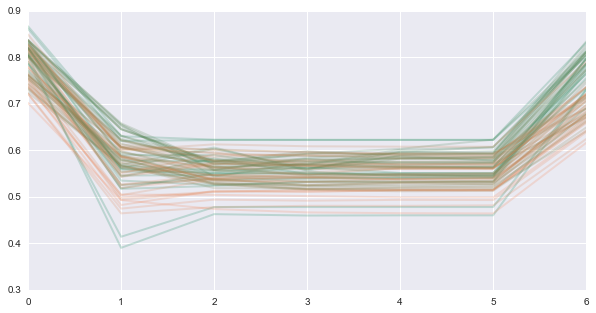

In [114]:
def plot_inf_iteration_loss(X, losses):
    losses = np.clip(losses, 0, 1)
    #     print(losses)
    n_iterations = len(X[0])
    color_gradient = np.array(range(len(losses)))/len(losses)
    for i in range(len(X)):# 
        if X[i] != []:
            X_plot = X[i]
            plt.plot(range(n_iterations), X_plot, 
                     #c =(np.abs(losses[i]),0.5,0.3), 
                     c = (i*1.0/len(losses),0.5,0.3),
                     linewidth=2.0, alpha=0.2)
  
    title = "experiments/figs/({})[Model<{}>(attractor<{},hid({}),h_hid({}),input_noise({})>, noise<{}>, n_iterations<{}>), Problem<{}>][epochs<{}>, repetitions<{}>]__{}.png".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['hid'],
                                                           ops['h_hid'],
                                                           INPUT_NOISE_LEVEL,
                                                           ops['attractor_noise_level'],
                                                           ops['n_attractor_iterations'],
                                                           ops['problem_type'],
                                                           TRAINING_EPOCHS, 
                                                           N_REPLICATIONS,
                                                           "mutual_information(Layersvs.TaskLoss)(not_scaled)")
#     plt.savefig(title, format='png', dpi=600)
    plt.show()


        
plot_inf_iteration_loss(iteration_mut_inf, losses_skipped)

In [415]:
entropy_collection

[1.1921958398998163,
 1.6797261887642663,
 1.6300746334530185,
 1.6528437037223711,
 1.6775441392082235,
 1.6858491036127714,
 1.6090863091898047,
 1.5687690108839523,
 1.5091072988368281,
 1.4751077885838615,
 1.4557351554227651,
 1.4382341161921623,
 1.3969214220908044,
 1.3672173487720305,
 1.3270357708726856,
 1.3144872043564022,
 1.3075553122681256,
 1.2629557486788328,
 1.2431738317092462,
 1.2371546861801894,
 1.2244033463076938,
 1.2219736849143785,
 1.2119211019550229,
 1.2073436786630338,
 1.1999992393389098,
 1.1926315719361062,
 1.1977247036880967,
 1.189049034778201,
 1.1910711856880136,
 1.1919165668517553,
 1.1677611408229041,
 1.1650922398922876,
 1.1999783252864031,
 1.1873178359353307,
 1.2103319919243642,
 1.2551337861383824,
 1.2717307619795868,
 1.261998509622752,
 1.2737456081910152,
 1.2515915968415219,
 1.2453032960579944,
 1.2297658871015069,
 1.2249781087747409,
 1.2241208346653933,
 1.2196885235279871,
 1.2092050927101272,
 1.2076814967451379,
 1.199187256776

In [25]:
import matplotlib.cm as cm

def plot_entropy_scatter(X, losses):
    ids = [0]
    for i in range(len(losses)):
        if losses[i] == 0.0:
            ids.append(i)
    print(ids)    
    colors = cm.rainbow(np.linspace(0, 1, len(ids)-1))
    for i in range(len(ids)-1):
        x = X[ids[i]:ids[i+1]]
        y = losses[ids[i]:ids[i+1]]
        color_gradient = np.array(range(len(x)))/len(x)
        plt.scatter(x, y, s=10, alpha=0.6, c=color_gradient)
        plt.plot(x, y, linewidth=0.8, alpha=0.2, c=colors[i])
#     plt.colorbar()
    title = "../attractor_net_notebooks/experiments/figs/({})[Model<{}>(attractor<{},hid({}),h_hid({}),input_noise({})>, noise<{}>, n_iterations<{}>), Problem<{}>][epochs<{}>, repetitions<{}>]__{}.png".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['hid'],
                                                           ops['h_hid'],
                                                           INPUT_NOISE_LEVEL,
                                                           ops['attractor_noise_level'],
                                                           ops['n_attractor_iterations'],
                                                           ops['problem_type'],
                                                           TRAINING_EPOCHS, 
                                                           N_REPLICATIONS,
                                                           "30repts_vectorentropy_vs_taskloss(projection2 5-10, bins{})".format(8))
#     plt.savefig(title, format='png', dpi=600)
    
plot_entropy_scatter(entropy_collection1, MIS.losses_task)
plt.show()

[0]


# Noise removal plots

In [28]:
MIS_saved_10attractorsteps_5everythingelse = MIS

# Analyze Losses

In [11]:
def normalize_epoch_count(a):
    "splits the array into separate sessions and normalizes each session by its maximum id (epoch number)"
    maxs = []
    ids = []
    for i in range(len(a) - 1):
        if a[i+1] < a[i]:
            maxs.append(a[i])
            ids.append(i+1)
    maxs.append(a[-1])
    
    a_split = (np.split(a, ids))
    a_split_norm = [1.0*a_split[i]/maxs[i] for i in range(len(maxs))]
#     print(a_split_norm)
    return np.concatenate(a_split_norm, axis=0), ids

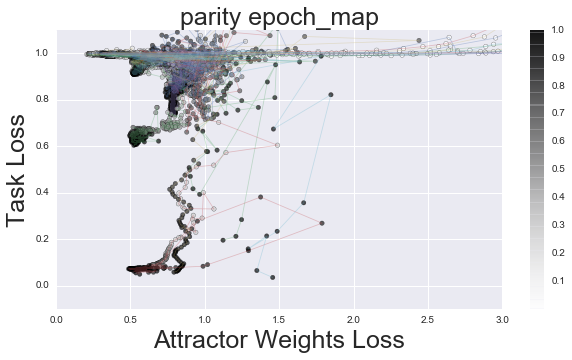

In [18]:
def plot_loss_vs_loss_vs_values(x, y, values, x_label="", y_label="", value_name="", ops=ops, comment=''):
    # Plot...
    plt.scatter(x, y, c=values, s=20, alpha=0.5) # 10*np.arange(1.0, 50.0)
    plt.xlabel(x_label, fontsize=25)
    plt.ylabel(y_label, fontsize=25)
    plt.title("{}".format(value_name), fontsize=25)
    plt.colorbar()
    title = "experiments/figs/({})[Model<{}>(attractor<{},hid({}),h_hid({}),input_noise({})>, noise<{}>, n_iterations<{}>), Problem<{}>][epochs<{}>, repetitions<{}>]__{}.png".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['hid'],
                                                           ops['h_hid'],
                                                           INPUT_NOISE_LEVEL,
                                                           ops['attractor_noise_level'],
                                                           ops['n_attractor_iterations'],
                                                           ops['problem_type'],
                                                           TRAINING_EPOCHS, 
                                                           N_REPLICATIONS,
                                                           comment)
    
    plt.axis([0, 3, -0.1, 1.1]) 
#     plt.savefig(title, format='png', dpi=600)

def plot_loss_vs_loss_vs_values_lines(x, y, values, ids_split, x_label="", y_label="", value_name="", ops=ops, comment=''):
    # Plot...
    x_list = np.split(x, ids_split)
    y_list = np.split(y, ids_split)
    values_list = np.split(values, ids_split)
    for i in range(len(ids_split) + 1):# 
        x = x_list[i]
        y = y_list[i]
        values = values_list[i]
        plt.scatter(x, y, c=values, s=20, alpha=0.7) # 10*np.arange(1.0, 50.0)
        plt.plot(x, y, linewidth=0.8, alpha=0.3)
        
    plt.xlabel(x_label, fontsize=25)
    plt.ylabel(y_label, fontsize=25)
    plt.title("{}".format(value_name), fontsize=25)
    plt.colorbar()
    title = "../attractor_net_notebooks/experiments/figs/({})[Model<{}>(attractor<{},hid({}),h_hid({}),input_noise({})>, noise<{}>, seq_len<{}>,n_iterations<{}>), Problem<{}>][epochs<{}>, repetitions<{}>]__{}.png".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['hid'],
                                                           ops['h_hid'],
                                                           INPUT_NOISE_LEVEL,
                                                           SEQ_LEN,
                                                           ops['attractor_noise_level'],
                                                           ops['n_attractor_iterations'],
                                                           ops['problem_type'],
                                                           TRAINING_EPOCHS, 
                                                           N_REPLICATIONS,
                                                           ops['attractor_regularization'],
                                                           comment)
    
    plt.axis([0, 3, -0.1, 1.1]) 
    plt.savefig(title, format='png', dpi=600)


epoch_normalized, ids_split = normalize_epoch_count(WS.epoch_number_history)
plot_loss_vs_loss_vs_values_lines(WS.losses_att, 
                            WS.losses_task,
                            epoch_normalized,
                            ids_split,
                           'Attractor Weights Loss',
                           'Task Loss',
                           ops['problem_type'] + ' epoch_map', 
                           comment = "Test_acc_mean<{:.4f}>, <bothlosses>".format(np.mean(saved_test_acc)))
# plt.savefig('figs/' + "{}vs{}vs{}__".format(x_label, y_label, value_name) + 
#                "NoiseLambda_{}__Architecture_{}".format(str(ops['attractor_noise_level']), model_type))
plt.show()



In [65]:
import datetime

def save_results(ops, saved_train_acc, saved_test_acc, saved_att_loss, comment):
        saved_train_acc = np.array(saved_train_acc)
        saved_test_acc = np.array(saved_test_acc)
        saved_att_loss = np.array(saved_att_loss)
        np.set_printoptions(precision=3)
        results = "\n<RESULTS>:\ntype: \t\t\tmean: \t var: \t\n"
        results += "{} \t{:.4f} \t {:.4f}\n".format("saved_train_acc", np.mean(saved_train_acc), np.var(saved_train_acc))
        results += "{} \t\t{:.4f} \t {:.4f}\n".format("saved_test_acc", np.mean(saved_test_acc), np.var(saved_test_acc))
        results += "{} \t\t{:.4f} \t {:.4f}\n".format("saved_att_loss", np.mean(saved_att_loss), np.var(saved_att_loss))
        
        results += "TRAIN:" + np.array2string(saved_train_acc, formatter={'float_kind':lambda x: "%.3f" % x})
        results += "\nTEST:" + np.array2string(saved_test_acc, formatter={'float_kind':lambda x: "%.3f" % x})
        results += "\nATT_LOSS:" + np.array2string(saved_att_loss, formatter={'float_kind':lambda x: "%.3f" % x})
        #         results += "{} \t {:.4f} \t {:.4f}\n".format("saved_att_loss", np.mean(saved_att_loss), np.var(saved_att_loss))


        title = "../attractor_net_notebooks/experiments/results/{}.txt".format(ops['problem_type']) 
        text = """\n
({}): {}
<NETWORK>:
model_type: \t\t{},
hid: \t\t\t{}, 
h_hid: \t\t\t{}
n_attractor_iterations: {},
attractor_dynamics: \t{}
attractor_noise_level: \t{}
attractor_noise_type: \t{}
attractor_regu-n: \t{}(lambda:{})
TRAIN/TEST_SIZE: \t{}/{}, SEQ_LEN: {}""".format(datetime.date.today(), comment, ops['model_type'], ops['hid'], ops['h_hid'], ops['n_attractor_iterations'], 
                      ops['attractor_dynamics'], ops['attractor_noise_level'], ops['attractor_noise_type'],
                        ops['attractor_regularization'], ops['attractor_regularization_lambda'],
                          N_TRAIN, N_TEST, SEQ_LEN)
           
        text += results
        print(text)
        with open(title, "a") as myfile:
            myfile.write(text)
            print("Saved Results Successfully")
        
comment = "both losses used for attractor training"
save_results(ops, saved_train_acc, saved_test_acc, saved_att_loss, comment)




(2018-03-19): both losses used for attractor training
<NETWORK>:
model_type: 		GRU,
hid: 			5, 
h_hid: 			10
n_attractor_iterations: 0,
attractor_dynamics: 	projection2
attractor_noise_level: 	0.2
attractor_noise_type: 	bernoilli
attractor_regu-n: 	l2(lambda:0.05)
TRAIN/TEST_SIZE: 	1000/1000, SEQ_LEN: 12
<RESULTS>:
type: 			mean: 	 var: 	
saved_train_acc 	0.8055 	 0.0132
saved_test_acc 		0.5912 	 0.0217
saved_att_loss 		1.0049 	 0.0000
TRAIN:[0.646 0.749 0.766 0.699 0.685 0.996 0.731 0.763 0.740 0.690 1.000 0.694
 0.736 0.763 0.766 0.732 0.940 0.999 0.658 0.969 0.902 0.822 0.712 0.856
 0.989 0.733 1.000 0.752 0.777 0.901]
TEST:[0.498 0.520 0.562 0.502 0.510 0.868 0.499 0.528 0.506 0.503 0.990 0.499
 0.513 0.481 0.572 0.488 0.564 0.825 0.515 0.772 0.559 0.547 0.512 0.545
 0.762 0.506 0.995 0.524 0.487 0.587]
ATT_LOSS:[1.005 1.005 1.005 1.005 1.005 1.005 1.004 1.005 1.005 1.005 1.005 1.005
 1.005 1.004 1.005 1.004 1.005 1.005 1.005 1.005 1.005 1.005 1.005 1.005
 1.005 1.005 1.005 1.005

In [33]:
saved_att_loss

[0.27380559]

In [ ]:
saved_train_acc = []
saved_test_acc = []
saved_epoch = []

In [ ]:
get_mean_var(saved_test_acc)

In [ ]:
np.mean(saved_test_acc)
